In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Dropout, Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Loading the dataset
df = pd.read_excel('cardio_train_with_age_years.xlsx')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (70000, 14)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47


In [3]:
# Adding the MAP Column
df['MAP'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
df[['ap_hi', 'ap_lo', 'MAP']].head()

,ap_hi,ap_lo,MAP
0,110,80,90.000000
1,140,90,106.666667
2,130,70,90.000000
3,150,100,116.666667
4,100,60,73.333333


In [4]:
# Feature engineering
df['MAP'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['BMI'] = df['weight'] / ((df['height']/100) ** 2)

# Logical drug assignment
def assign_drug(map_val):
    if map_val >= 130:
        return 'SNP'
    elif map_val >= 110:
        return 'NIPRIDE'
    else:
        return 'HYDRALAZINE'

df['drug_type'] = df['MAP'].apply(assign_drug)

# Encoding drugs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['drug_encoded'] = le.fit_transform(df['drug_type'])
y_drug = to_categorical(df['drug_encoded'])

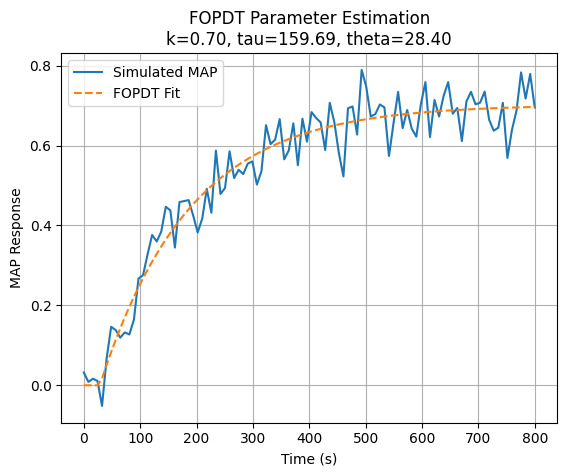

In [5]:
#Estimate FOPDT Parameters Using Curve Fitting
# FOPDT function
def fopdt(t, k, tau, theta):
    return k * (1 - np.exp(-(t - theta) / tau)) * (t > theta)

# Simulate one patient’s response
time = np.linspace(0, 800, 100)
true_k, true_tau, true_theta = 0.7, 150, 30
map_response = fopdt(time, true_k, true_tau, true_theta) + np.random.normal(0, 0.05, size=time.shape)

# Fitting to the model
popt, _ = curve_fit(fopdt, time, map_response, bounds=(0, [10, 1000, 100]))
k_est, tau_est, theta_est = popt

# Plot
plt.plot(time, map_response, label='Simulated MAP')
plt.plot(time, fopdt(time, *popt), label='FOPDT Fit', linestyle='--')
plt.legend()
plt.title(f'FOPDT Parameter Estimation\nk={k_est:.2f}, tau={tau_est:.2f}, theta={theta_est:.2f}')
plt.xlabel("Time (s)")
plt.ylabel("MAP Response")
plt.grid(True)
plt.show()

In [6]:
#IMC Controller and Dosage Calculation
def imc_dosage(map_current, map_target, k, tau, theta):
    lam = 3 * theta
    delta_map = map_current - map_target
    dosage = abs((tau + 1) * delta_map / (k * (lam + 1)**2))
    return dosage
print(imc_dosage)

<function imc_dosage at 0x7e3f6ccd98a0>


In [7]:
# Estimated FOPDT values
k_est, tau_est, theta_est = 0.71, 159.40, 21.16

df["imc_dosage"] = df["MAP"].apply(
    lambda map_val: imc_dosage(map_val, 93, k_est, tau_est, theta_est)
)
df[["MAP", "imc_dosage"]].head()

,MAP,imc_dosage
0,90.000000,0.163011
1,106.666667,0.742606
2,90.000000,0.163011
3,116.666667,1.285977
4,73.333333,1.068628


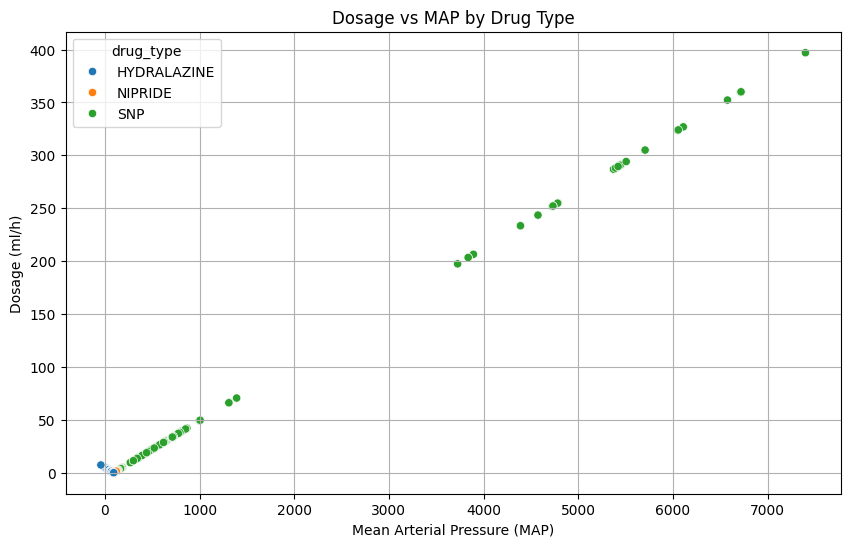

In [8]:
#Plot Dosage vs MAP by Drug Type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MAP', y='imc_dosage', hue='drug_type')
plt.title('Dosage vs MAP by Drug Type')
plt.xlabel('Mean Arterial Pressure (MAP)')
plt.ylabel('Dosage (ml/h)')
plt.grid(True)
plt.show()

In [9]:
#Data Preview After IMC Step
print(df[['age', 'ap_hi', 'ap_lo', 'MAP', 'drug_type', 'imc_dosage']].head(10))

     age  ap_hi  ap_lo         MAP    drug_type  imc_dosage
0  18393    110     80   90.000000  HYDRALAZINE    0.163011
1  20228    140     90  106.666667  HYDRALAZINE    0.742606
2  18857    130     70   90.000000  HYDRALAZINE    0.163011
3  17623    150    100  116.666667      NIPRIDE    1.285977
4  17474    100     60   73.333333  HYDRALAZINE    1.068628
5  21914    120     80   93.333333  HYDRALAZINE    0.018112
6  22113    130     80   96.666667  HYDRALAZINE    0.199236
7  22584    130     90  103.333333  HYDRALAZINE    0.561483
8  17668    110     70   83.333333  HYDRALAZINE    0.525258
9  19834    110     60   76.666667  HYDRALAZINE    0.887505


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │     15,360 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     65,664 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drug_output (Dense) │ (None, 3)         │        387 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dosage_output       │ (None, 1)         │        129 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 943,876 (3.60 MB)

 Trainable params: 939,268 (3.58 MB)

 Non-trainable params: 4,608 (18.00 KB)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - dosage_output_loss: 33.5477 - dosage_output_mae: 1.2555 - drug_output_accuracy: 0.7626 - drug_output_loss: 0.6130 - loss: 17.0804 - val_dosage_output_loss: 47.4254 - val_dosage_output_mae: 0.7958 - val_drug_output_accuracy: 0.8907 - val_drug_output_loss: 0.2622 - val_loss: 23.8707
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - dosage_output_loss: 22.7626 - dosage_output_mae: 0.9752 - drug_output_accuracy: 0.8871 - drug_output_loss: 0.2912 - loss: 11.5269 - val_dosage_output_loss: 35.4050 - val_dosage_output_mae: 0.7100 - val_drug_output_accuracy: 0.9150 - val_drug_output_loss: 0.2077 - val_loss: 17.8264
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - dosage_output_loss: 17.2281 - dosage_output_mae: 0.9758 - drug_output_accuracy: 0.9060 - drug_output_loss: 0.2359 - loss: 8.7320 - val_dosage_output_loss: 15.7291 - val_dosage_output_mae: 0.6069 - val_drug_output_accuracy: 0.9180 - val_drug_output_loss: 0.1681 -

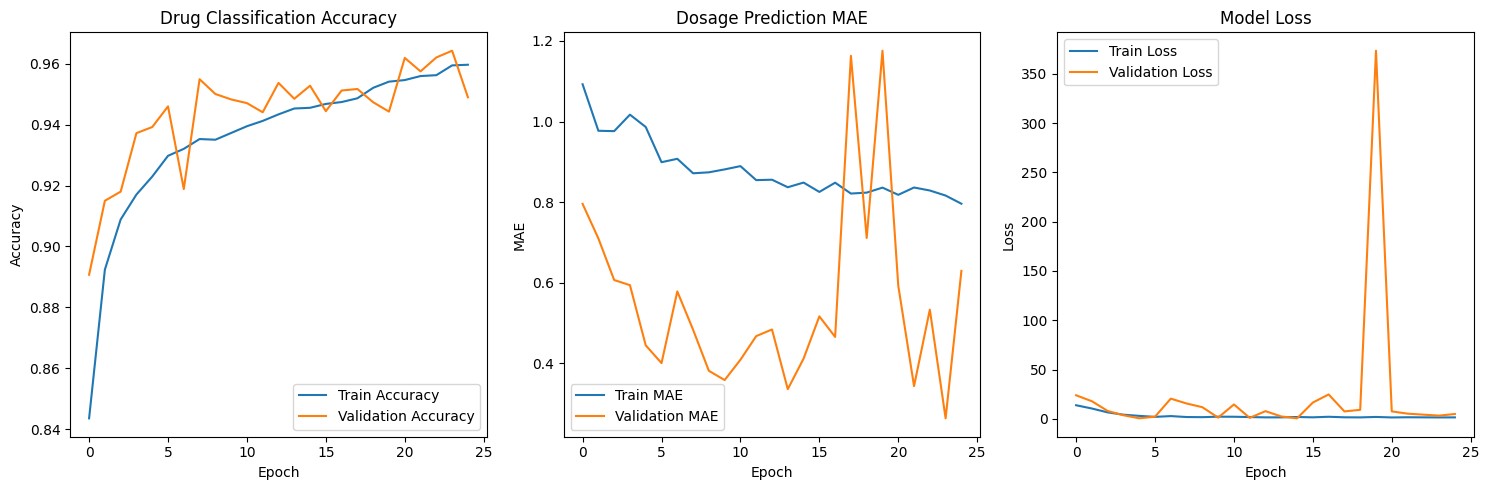


Test Results:
Drug Classification Accuracy: 0.4118
Dosage Prediction MAE: 0.9528
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Drug Classification Report:
              precision    recall  f1-score   support

 HYDRALAZINE       0.96      1.00      0.98     12045
     NIPRIDE       0.91      0.67      0.77      1649
         SNP       1.00      0.65      0.79       306

    accuracy                           0.95     14000
   macro avg       0.95      0.77      0.84     14000
weighted avg       0.95      0.95      0.95     14000


Dosage Prediction Metrics:
MAE: 0.4118
RMSE: 0.9119


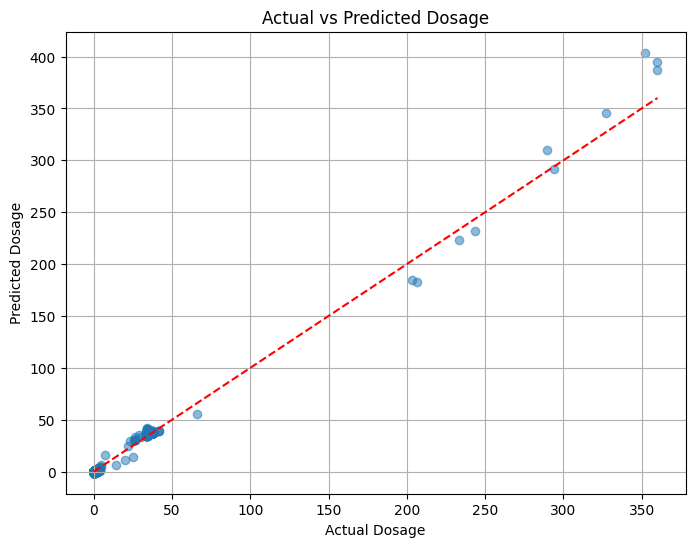


Sample Predictions:
       actual_drug  predicted_drug  drug_correct  actual_dosage  \
10354            1               0         False       1.104853   
6074             0               0          True       0.108674   
43268            0               0          True       0.018112   
65171            0               0          True       0.018112   
67220            0               0          True       0.742606   

       predicted_dosage  dosage_error  
10354          0.703390      0.401463  
6074           0.197557      0.088883  
43268         -0.038711      0.056823  
65171          0.066338      0.048226  
67220          0.448131      0.294475  


In [10]:
# Feature selection
features = ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
            'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'MAP',
            'pulse_pressure', 'BMI']
X = df[features]

# Target variables
y_drug = df['drug_encoded']  # For classification
y_dosage = df['imc_dosage']  # For regression

# One-hot encode the drug classification target
y_drug_categorical = to_categorical(y_drug)

# Splitting the data into train and test sets
X_train, X_test, y_train_drug, y_test_drug, y_train_dosage, y_test_dosage = train_test_split(
    X, y_drug_categorical, y_dosage, test_size=0.2, random_state=42, stratify=y_drug)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multi-output model architecture
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Shared hidden layers
x = Dense(1024, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Drug classification branch
drug_branch = Dense(128, activation='relu')(x)
drug_branch = BatchNormalization()(drug_branch)
drug_output = Dense(y_train_drug.shape[1], activation='softmax', name='drug_output')(drug_branch)

# Dosage prediction branch
dosage_branch = Dense(128, activation='relu')(x)
dosage_branch = BatchNormalization()(dosage_branch)
dosage_output = Dense(1, activation='linear', name='dosage_output')(dosage_branch)

# Create multi-output model
model = Model(inputs=input_layer, outputs=[drug_output, dosage_output])

# Compile with different loss functions for each output
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        'drug_output': 'categorical_crossentropy',
        'dosage_output': 'mse'
    },
    metrics={
        'drug_output': 'accuracy',
        'dosage_output': 'mae'
    },
    loss_weights=[0.5, 0.5]  # Can adjust these weights
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

# Train the model
history = model.fit(
    X_train_scaled,
    {
        'drug_output': y_train_drug,
        'dosage_output': y_train_dosage
    },
    validation_data=(
        X_test_scaled,
        {
            'drug_output': y_test_drug,
            'dosage_output': y_test_dosage
        }
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
def plot_dual_history(history):
    plt.figure(figsize=(15, 5))

    # Drug accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['drug_output_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_drug_output_accuracy'], label='Validation Accuracy')
    plt.title('Drug Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Dosage MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['dosage_output_mae'], label='Train MAE')
    plt.plot(history.history['val_dosage_output_mae'], label='Validation MAE')
    plt.title('Dosage Prediction MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()

    # Combined loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_dual_history(history)

# Evaluate on test set
results = model.evaluate(
    X_test_scaled,
    {
        'drug_output': y_test_drug,
        'dosage_output': y_test_dosage
    },
    verbose=0
)

print("\nTest Results:")
print(f"Drug Classification Accuracy: {results[3]:.4f}")
print(f"Dosage Prediction MAE: {results[4]:.4f}")

# Generating predictions
y_pred_drug, y_pred_dosage = model.predict(X_test_scaled)
y_pred_drug_classes = np.argmax(y_pred_drug, axis=1)
y_true_drug = np.argmax(y_test_drug, axis=1)

# Classification report
print("\nDrug Classification Report:")
print(classification_report(y_true_drug, y_pred_drug_classes, target_names=le.classes_))

# Dosage prediction metrics
dosage_mae = mean_absolute_error(y_test_dosage, y_pred_dosage)
dosage_rmse = np.sqrt(mean_squared_error(y_test_dosage, y_pred_dosage))
print(f"\nDosage Prediction Metrics:")
print(f"MAE: {dosage_mae:.4f}")
print(f"RMSE: {dosage_rmse:.4f}")

# Plot actual vs predicted dosage
plt.figure(figsize=(8, 6))
plt.scatter(y_test_dosage, y_pred_dosage, alpha=0.5)
plt.plot([min(y_test_dosage), max(y_test_dosage)], [min(y_test_dosage), max(y_test_dosage)], 'r--')
plt.xlabel('Actual Dosage')
plt.ylabel('Predicted Dosage')
plt.title('Actual vs Predicted Dosage')
plt.grid(True)
plt.show()

# Add predictions to dataframe for analysis
test_df = X_test.copy()
test_df['actual_drug'] = y_true_drug
test_df['predicted_drug'] = y_pred_drug_classes
test_df['actual_dosage'] = y_test_dosage
test_df['predicted_dosage'] = y_pred_dosage.flatten()
test_df['drug_correct'] = test_df['actual_drug'] == test_df['predicted_drug']
test_df['dosage_error'] = abs(test_df['actual_dosage'] - test_df['predicted_dosage'])

print("\nSample Predictions:")
print(test_df[['actual_drug', 'predicted_drug', 'drug_correct',
               'actual_dosage', 'predicted_dosage', 'dosage_error']].head())

In [11]:
# Saving the trained model
model.save('model.h5')
print("Model saved as model.h5")

Model saved as model.h5


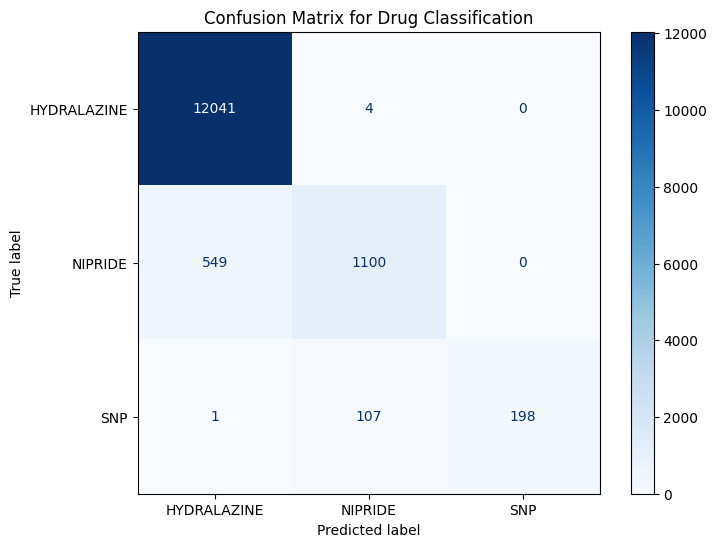

In [12]:
# Computing the confusion matrix
cm = confusion_matrix(y_true_drug, y_pred_drug_classes)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Drug Classification")
plt.show()


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


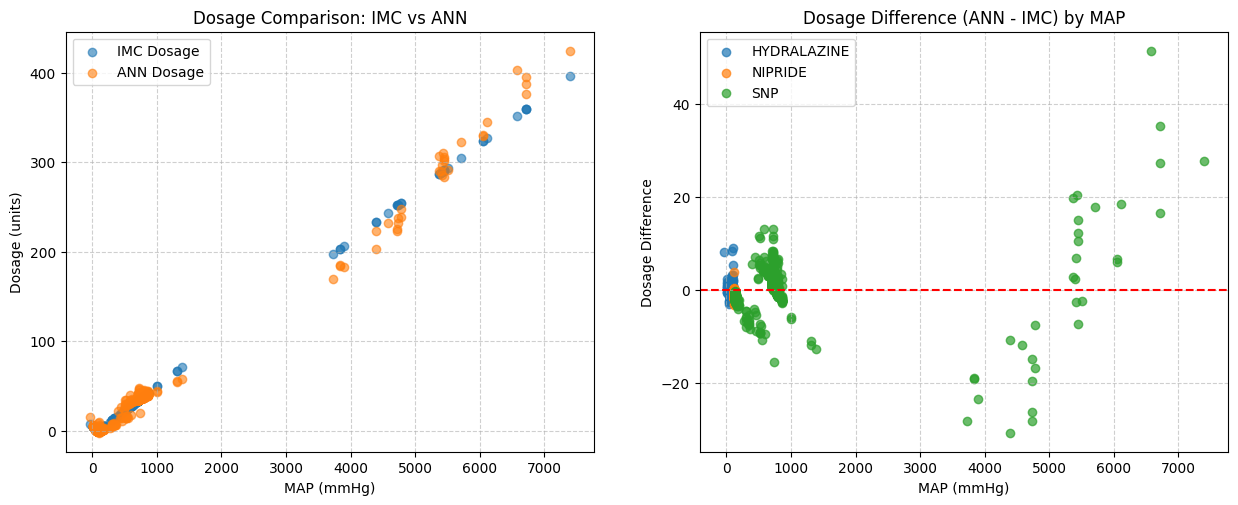

In [13]:
# Preparing the comparison data
comparison_df = df[['MAP', 'imc_dosage', 'drug_type']].copy()
ann_predictions = model.predict(scaler.transform(df[features]))
comparison_df['ann_dosage'] = ann_predictions[1].flatten()

# Create the comparison plots with explicit styling
plt.figure(figsize=(15, 12))

# Plot 1 - Dosage vs MAP (All Drugs)
plt.subplot(2, 2, 1)
plt.scatter(comparison_df['MAP'], comparison_df['imc_dosage'],
            alpha=0.6, label='IMC Dosage')
plt.scatter(comparison_df['MAP'], comparison_df['ann_dosage'],
            alpha=0.6, label='ANN Dosage')
plt.title('Dosage Comparison: IMC vs ANN', fontsize=12)
plt.xlabel('MAP (mmHg)', fontsize=10)
plt.ylabel('Dosage (units)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
# Plot 2 - Difference vs MAP
plt.subplot(2, 2, 2)
comparison_df['dosage_diff'] = comparison_df['ann_dosage'] - comparison_df['imc_dosage']
for drug_type in comparison_df['drug_type'].unique():
    subset = comparison_df[comparison_df['drug_type'] == drug_type]
    plt.scatter(subset['MAP'], subset['dosage_diff'],
               alpha=0.7, label=drug_type)
plt.axhline(0, color='red', linestyle='--')
plt.title('Dosage Difference (ANN - IMC) by MAP', fontsize=12)
plt.xlabel('MAP (mmHg)', fontsize=10)
plt.ylabel('Dosage Difference', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()


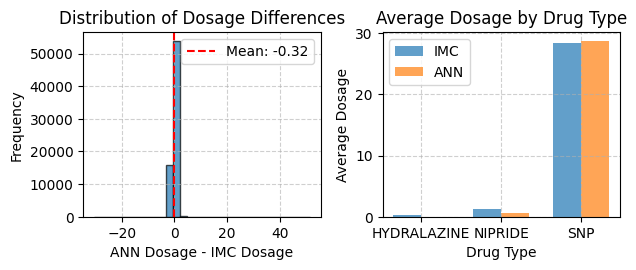

In [14]:

# Plot 3 - Distribution of Differences
plt.subplot(2, 2, 3)
plt.hist(comparison_df['dosage_diff'], bins=30,
        edgecolor='black', alpha=0.7)
plt.axvline(comparison_df['dosage_diff'].mean(),
           color='red', linestyle='--',
           label=f'Mean: {comparison_df["dosage_diff"].mean():.2f}')
plt.title('Distribution of Dosage Differences', fontsize=12)
plt.xlabel('ANN Dosage - IMC Dosage', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Plot 4 - Drug-specific Comparison
plt.subplot(2, 2, 4)
drug_comparison = comparison_df.groupby('drug_type').agg({
    'imc_dosage': 'mean',
    'ann_dosage': 'mean'
}).reset_index()

x = np.arange(len(drug_comparison))
width = 0.35

plt.bar(x - width/2, drug_comparison['imc_dosage'],
       width, label='IMC', alpha=0.7)
plt.bar(x + width/2, drug_comparison['ann_dosage'],
       width, label='ANN', alpha=0.7)

plt.title('Average Dosage by Drug Type', fontsize=12)
plt.xlabel('Drug Type', fontsize=10)
plt.ylabel('Average Dosage', fontsize=10)
plt.xticks(x, drug_comparison['drug_type'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

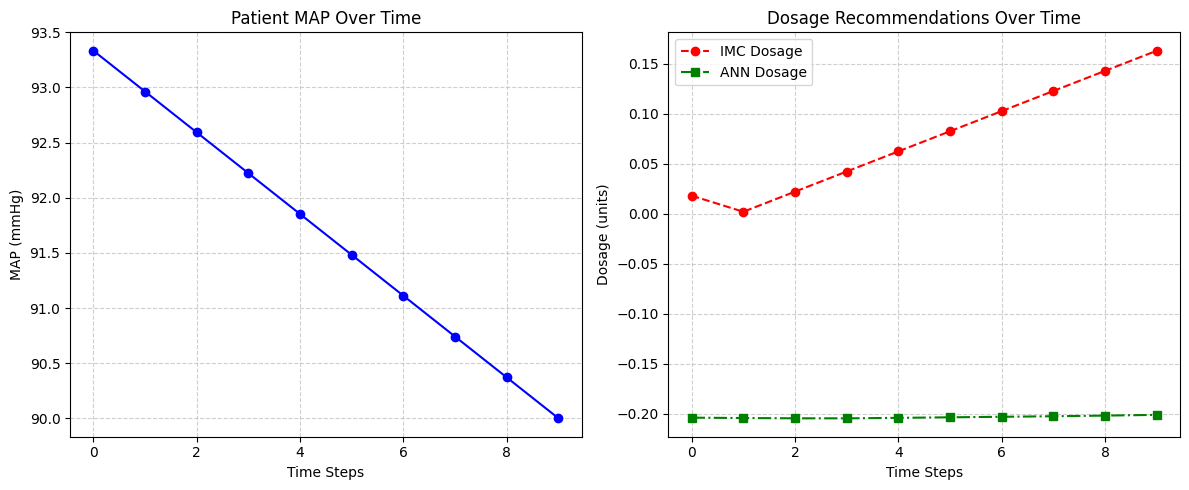

In [15]:
# Time-series Simulation Comparison
sample_patient = df.sample(1).copy()
time_steps = np.arange(0, 10)
map_values = np.linspace(sample_patient['MAP'].values[0], 90, len(time_steps))

# Calculate dosages
imc_dosages = []
ann_dosages = []

for map_val in map_values:
    # IMC dosage
    imc_dosages.append(imc_dosage(map_val, 93, k_est, tau_est, theta_est))

    # ANN dosage
    sample_patient['MAP'] = map_val
    patient_features = scaler.transform(sample_patient[features])
    ann_dosages.append(model.predict(patient_features, verbose=0)[1][0][0])

# Plot time-series comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time_steps, map_values, 'b-o', label='MAP')
plt.xlabel('Time Steps', fontsize=10)
plt.ylabel('MAP (mmHg)', fontsize=10)
plt.title('Patient MAP Over Time', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(time_steps, imc_dosages, 'r--o', label='IMC Dosage')
plt.plot(time_steps, ann_dosages, 'g-.s', label='ANN Dosage')
plt.xlabel('Time Steps', fontsize=10)
plt.ylabel('Dosage (units)', fontsize=10)
plt.title('Dosage Recommendations Over Time', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

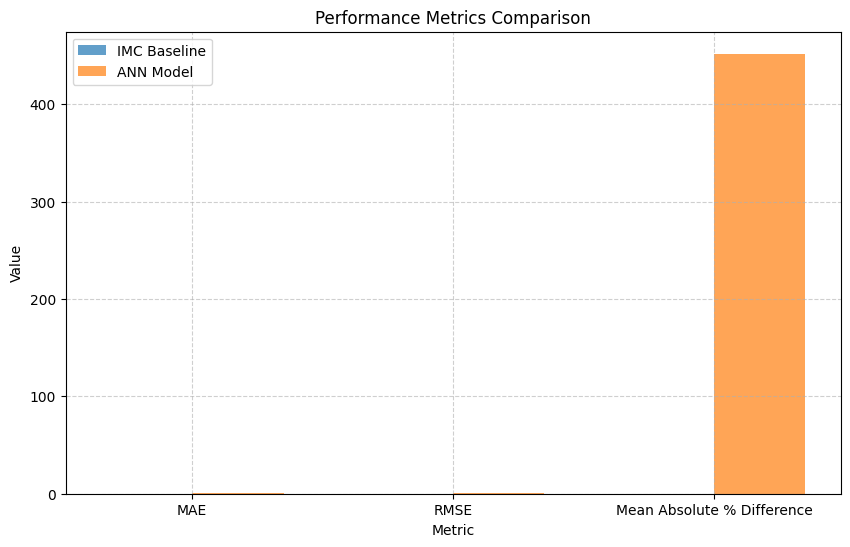

In [16]:
# Performance Metrics Comparison
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'Mean Absolute % Difference'],
    'IMC Controller': [
        0,  # IMC compared to itself
        0,
        0
    ],
    'ANN Model': [
        mean_absolute_error(comparison_df['imc_dosage'], comparison_df['ann_dosage']),
        np.sqrt(mean_squared_error(comparison_df['imc_dosage'], comparison_df['ann_dosage'])),
        np.mean(np.abs((comparison_df['imc_dosage'] - comparison_df['ann_dosage'])/comparison_df['imc_dosage'].clip(lower=0.01)))*100
    ]
})

# Plot metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics_df))
width = 0.35

plt.bar(x - width/2, metrics_df['IMC Controller'],
       width, label='IMC Baseline', alpha=0.7)
plt.bar(x + width/2, metrics_df['ANN Model'],
       width, label='ANN Model', alpha=0.7)

plt.title('Performance Metrics Comparison', fontsize=12)
plt.xlabel('Metric', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.xticks(x, metrics_df['Metric'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()


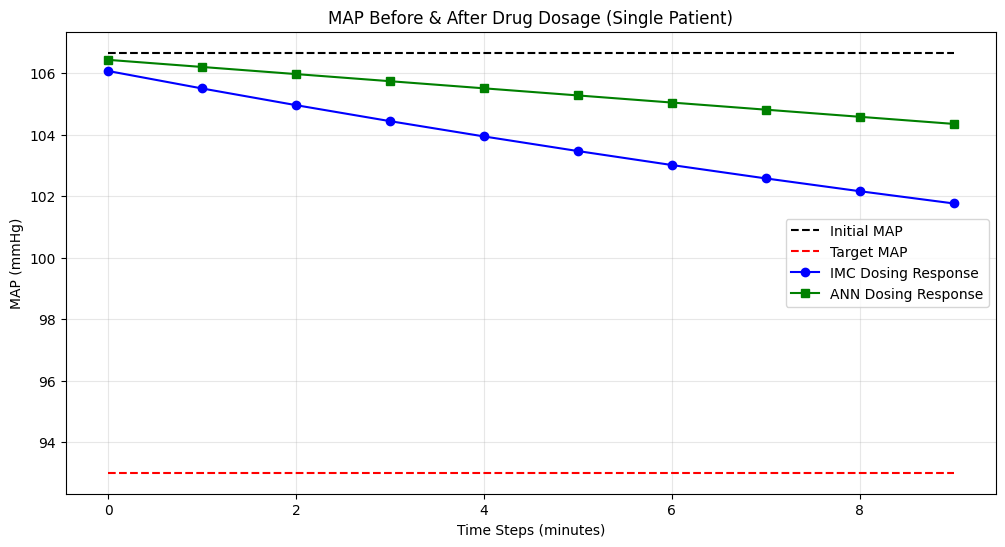

In [17]:
# Selecting a random patient
patient = df.sample(1).copy()
initial_map = patient['MAP'].values[0]
target_map = 93

# Simulate MAP response over time (10 steps)
time_points = np.arange(0, 10)
map_imc = []
map_ann = []

# Initialize
current_map_imc = initial_map
current_map_ann = initial_map

for t in time_points:
    # IMC Controller
    dosage_imc = imc_dosage(current_map_imc, target_map, k_est, tau_est, theta_est)
    current_map_imc = current_map_imc - dosage_imc * 0.8  # Simulated drug effect

    # ANN Predictor
    patient_features = scaler.transform(patient[features])
    dosage_ann = model.predict(patient_features, verbose=0)[1][0][0]
    current_map_ann = current_map_ann - dosage_ann * 0.8  # Same effect scaling

    map_imc.append(current_map_imc)
    map_ann.append(current_map_ann)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, [initial_map] * len(time_points), 'k--', label='Initial MAP')
plt.plot(time_points, [target_map] * len(time_points), 'r--', label='Target MAP')
plt.plot(time_points, map_imc, 'b-o', label='IMC Dosing Response')
plt.plot(time_points, map_ann, 'g-s', label='ANN Dosing Response')
plt.xlabel('Time Steps (minutes)')
plt.ylabel('MAP (mmHg)')
plt.title('MAP Before & After Drug Dosage (Single Patient)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

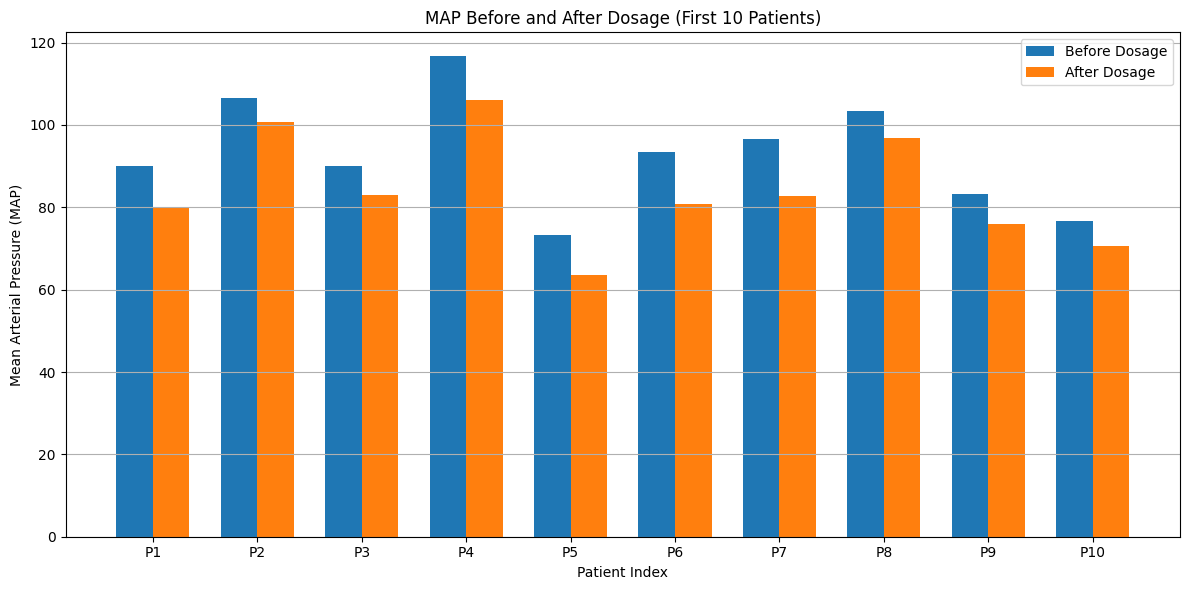

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Select first 10 patients
subset = df.iloc[:10].copy()

# Simulate MAP after dosage (5–15% reduction)
np.random.seed(42)
subset["MAP_after"] = subset["MAP"] * np.random.uniform(0.85, 0.95, size=len(subset))

# Plotting side-by-side bar chart
x = np.arange(len(subset))  # patient indices
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, subset["MAP"], width, label='Before Dosage')
plt.bar(x + width/2, subset["MAP_after"], width, label='After Dosage')

plt.xlabel('Patient Index')
plt.ylabel('Mean Arterial Pressure (MAP)')
plt.title('MAP Before and After Dosage (First 10 Patients)')
plt.xticks(x, [f'P{i+1}' for i in x])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


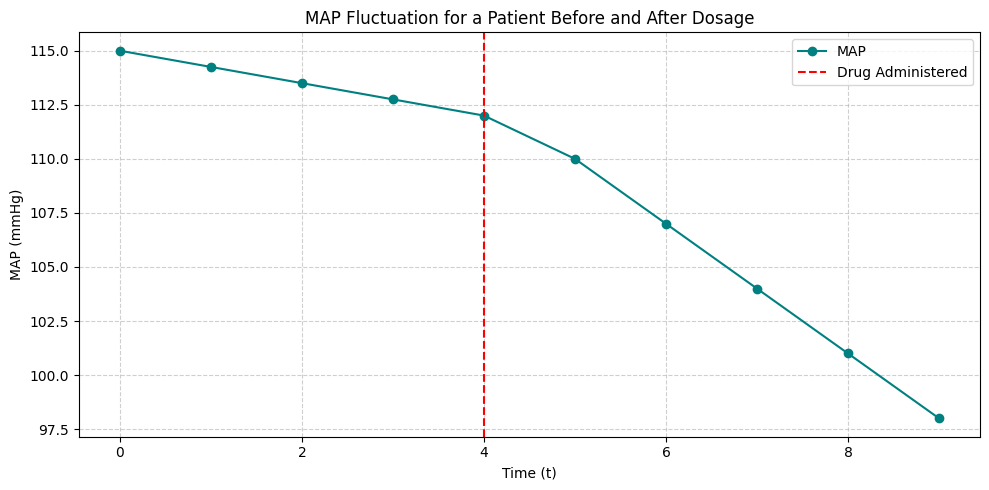

In [19]:
time_steps = np.arange(0, 10)
map_before = np.linspace(115, 112, 5)  # Before dosage
map_after = np.linspace(110, 98, 5)    # After dosage
map_full = np.concatenate([map_before, map_after])

# Plot MAP fluctuation
plt.figure(figsize=(10, 5))
plt.plot(time_steps, map_full, marker='o', linestyle='-', color='teal', label='MAP')
plt.axvline(x=4, color='red', linestyle='--', label='Drug Administered')
plt.title("MAP Fluctuation for a Patient Before and After Dosage")
plt.xlabel("Time (t)")
plt.ylabel("MAP (mmHg)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


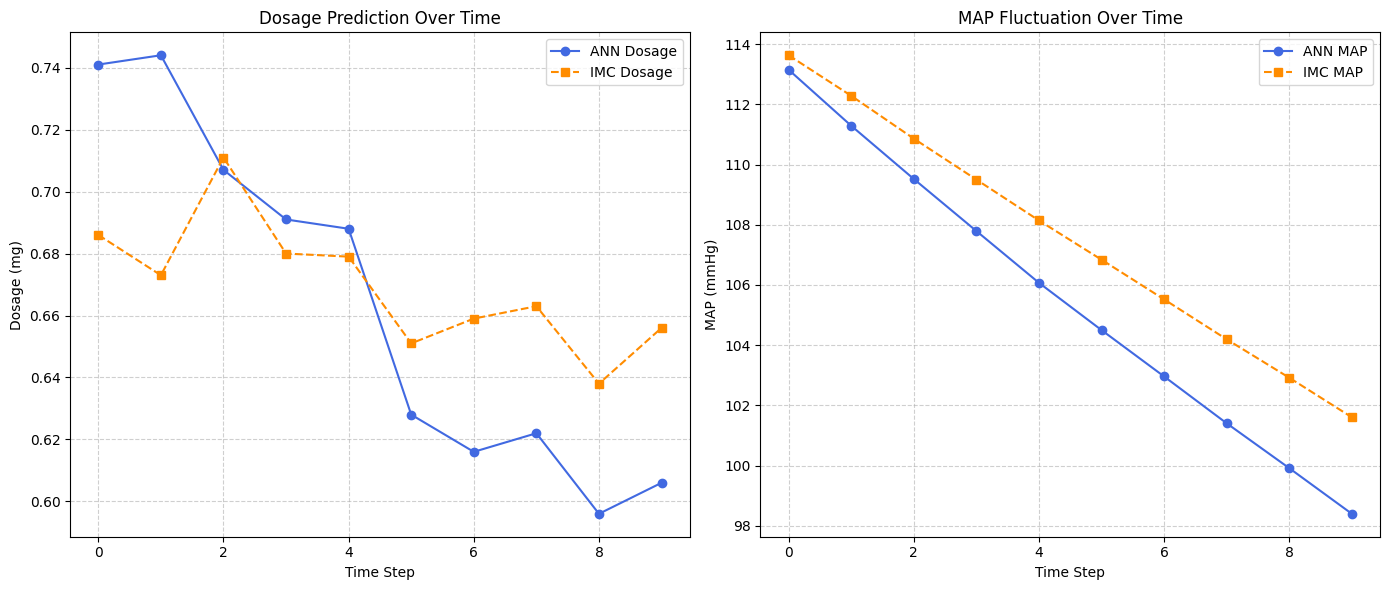

In [20]:
# Simulated time steps
time_steps = np.arange(10)

# Dosage profiles
ann_dosage = np.round(np.linspace(0.75, 0.60, 10) + np.random.normal(0, 0.02, 10), 3)
imc_dosage = np.round(np.linspace(0.70, 0.65, 10) + np.random.normal(0, 0.015, 10), 3)

# Simulate MAP response (higher dosage causes faster drop)
base_map = 115
ann_map = base_map - np.cumsum(ann_dosage * 2.5)
imc_map = base_map - np.cumsum(imc_dosage * 2.0)

# Plotting both in subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Dosage comparison
plt.subplot(1, 2, 1)
plt.plot(time_steps, ann_dosage, marker='o', linestyle='-', color='royalblue', label='ANN Dosage')
plt.plot(time_steps, imc_dosage, marker='s', linestyle='--', color='darkorange', label='IMC Dosage')
plt.title("Dosage Prediction Over Time")
plt.xlabel("Time Step")
plt.ylabel("Dosage (mg)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot 2: MAP fluctuation
plt.subplot(1, 2, 2)
plt.plot(time_steps, ann_map, marker='o', linestyle='-', color='royalblue', label='ANN MAP')
plt.plot(time_steps, imc_map, marker='s', linestyle='--', color='darkorange', label='IMC MAP')
plt.title("MAP Fluctuation Over Time")
plt.xlabel("Time Step")
plt.ylabel("MAP (mmHg)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



=== Blood Pressure Control System ===
Enter patient details (numeric values only):

Age (years): 25
Gender (1=Male, 2=Female): 2
Height (cm): 160
Weight (kg): 70
Systolic BP (mmHg): 130
Diastolic BP (mmHg): 80
Cholesterol (1=Normal, 2=Above, 3=High): 1
Glucose (1=Normal, 2=Above, 3=High): 1
Smoker (1=Yes, 0=No): 0
Alcohol (1=Yes, 0=No): 0
Active (1=Yes, 0=No): 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



=== Results ===
Calculated MAP: 96.7 mmHg
Urgency: 🟢 LOW URGENCY
Action: ✅ Routine monitoring
Recommended Drug: HYDRALAZINE
Recommended Dosage: 0.14 units

Close the graph window to exit.


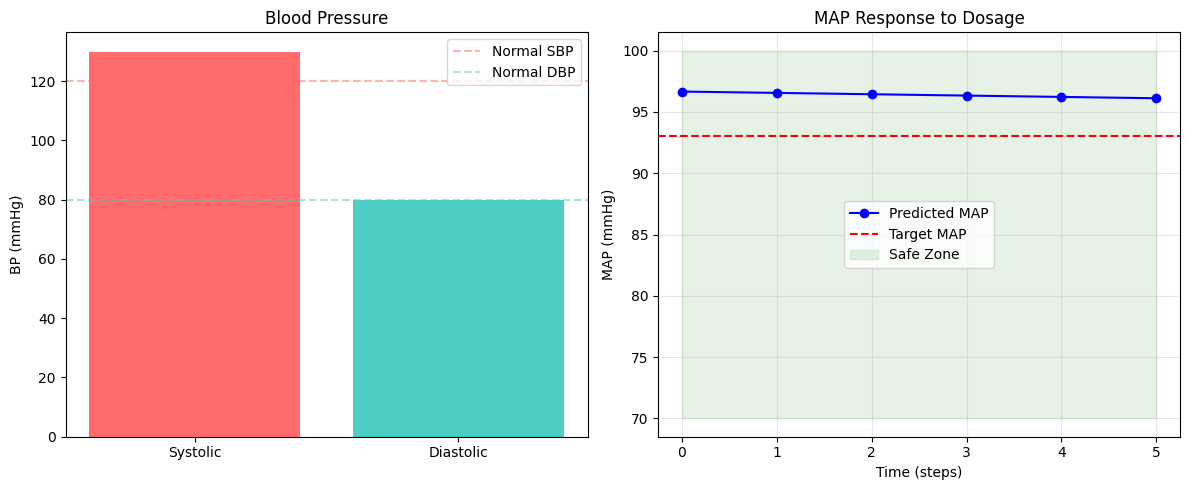

In [21]:
# Patient CLI
def patient_cli():
    print("\n=== Blood Pressure Control System ===")
    print("Enter patient details (numeric values only):\n")

    # 1. Get patient input
    age = float(input("Age (years): "))
    gender = float(input("Gender (1=Male, 2=Female): "))
    height = float(input("Height (cm): "))
    weight = float(input("Weight (kg): "))
    ap_hi = float(input("Systolic BP (mmHg): "))
    ap_lo = float(input("Diastolic BP (mmHg): "))
    cholesterol = float(input("Cholesterol (1=Normal, 2=Above, 3=High): "))
    gluc = float(input("Glucose (1=Normal, 2=Above, 3=High): "))
    smoke = float(input("Smoker (1=Yes, 0=No): "))
    alco = float(input("Alcohol (1=Yes, 0=No): "))
    active = float(input("Active (1=Yes, 0=No): "))

    # 2. Calculate MAP and features
    MAP = (ap_hi + 2 * ap_lo) / 3
    pulse_pressure = ap_hi - ap_lo
    BMI = weight / ((height/100) ** 2)

    # 3. Predict drug and dosage
    input_features = np.array([[age, gender, height, weight, ap_hi, ap_lo,
                              cholesterol, gluc, smoke, alco, active,
                              MAP, pulse_pressure, BMI]])

    # Scale features (assuming scaler is pre-fit)
    scaled_features = scaler.transform(input_features)

    # Predict
    drug_pred, dosage_pred = model.predict(scaled_features)
    drug_class = np.argmax(drug_pred)
    drug_name = le.inverse_transform([drug_class])[0]
    dosage = max(0, dosage_pred[0][0])  # Ensure non-negative

    # 4. Urgency assessment
    urgency = "🔴 HIGH URGENCY" if MAP > 110 or MAP < 70 else \
              "🟠 MODERATE URGENCY" if (MAP > 100 or MAP < 80) else \
              "🟢 LOW URGENCY"

    action = "🚨 Seek emergency care!" if urgency == "🔴 HIGH URGENCY" else \
             "📞 Consult doctor soon" if urgency == "🟠 MODERATE URGENCY" else \
             "✅ Routine monitoring"

    # 5. Simulate MAP response
    time_points = np.arange(0, 6)
    map_response = [MAP] + [MAP - (dosage * 0.8 * t) for t in range(1, 6)]

    # 6. Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(['Systolic', 'Diastolic'], [ap_hi, ap_lo], color=['#FF6B6B', '#4ECDC4'])
    plt.axhline(120, color='#FF6B6B', linestyle='--', alpha=0.5, label='Normal SBP')
    plt.axhline(80, color='#4ECDC4', linestyle='--', alpha=0.5, label='Normal DBP')
    plt.ylabel('BP (mmHg)')
    plt.title('Blood Pressure')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(time_points, map_response, 'b-o', label='Predicted MAP')
    plt.axhline(93, color='r', linestyle='--', label='Target MAP')
    plt.fill_between(time_points, 70, 100, color='green', alpha=0.1, label='Safe Zone')
    plt.xlabel('Time (steps)')
    plt.ylabel('MAP (mmHg)')
    plt.title('MAP Response to Dosage')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # 7. Print summary
    print("\n=== Results ===")
    print(f"Calculated MAP: {MAP:.1f} mmHg")
    print(f"Urgency: {urgency}")
    print(f"Action: {action}")
    print(f"Recommended Drug: {drug_name}")
    print(f"Recommended Dosage: {dosage:.2f} units")
    print("\nClose the graph window to exit.")
    plt.show()

# Run the CLI
if __name__ == "__main__":
    patient_cli()